<a href="https://colab.research.google.com/github/fuerdagegen/retail-sales-forecasting/blob/main/model_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

This notebook trains an XGBoost model on the cleaned Guayas dataset from the previous step.  
The setup installs XGBoost (for gradient-boosted trees) and imports core libraries for data handling, evaluation, and time-series-aware model selection.

In [ ]:
# Install XGBoost in the Colab environment
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 13.5 MB/s eta 0:00:00


In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Plotting
from matplotlib import pyplot as plt

# Model selection and evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# XGBoost
import xgboost as xgb

# Google Drive integration
from google.colab import drive

# Loading the data

This section loads the cleaned dataset produced in the previous notebook and prepares additional features required for XGBoost, including lagged values and simple rolling statistics.

In [ ]:
# Mount Drive and load the cleaned dataset
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/retail-sales-forecasting/df_train_sample.csv')

Mounted at /content/drive


In [ ]:
df_train.shape

(9319765, 10)

In [ ]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,0.0,False,2013,1,6,6,0.0


In [ ]:
# Date cutoff already applied in the export step; this is redundant but kept for safety
max_date = '2014-04-01'
df_train = df_train[df_train['date'] <= max_date]
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,96995,2013-01-02,0.0,False,2013,1,2,2,0.0
1,24,96995,2013-01-03,0.0,False,2013,1,3,3,0.0
2,24,96995,2013-01-04,0.0,False,2013,1,4,4,0.0
3,24,96995,2013-01-05,0.0,False,2013,1,5,5,0.0
4,24,96995,2013-01-06,0.0,False,2013,1,6,6,0.0


In [ ]:
# Convert promotion flag to integer for XGBoost
df_train['onpromotion'] = df_train['onpromotion'].apply(lambda x: 1 if x is True else 0)
print(df_train['onpromotion'])

0          0
1          0
2          0
3          0
4          0
          ..
9319760    0
9319761    0
9319762    0
9319763    0
9319764    0
Name: onpromotion, Length: 9319765, dtype: int64


In [ ]:
# Lag features for each (store, item) series
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df_train['lag_30'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(30)

In [ ]:
# Rolling standard deviation over the past 7 days (shifted to avoid leakage)
df_train['rolling_std_7'] = (
    df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales']
            .shift(1)
            .rolling(window=7)
            .std()
)

In [ ]:
# Weekend indicator: 1 for Saturday/Sunday, 0 otherwise
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_30,rolling_std_7,is_weekend
0,24,96995,2013-01-02,0.0,0,2013,1,2,2,0.0,NaN,NaN,NaN,NaN,0
1,24,96995,2013-01-03,0.0,0,2013,1,3,3,0.0,0.0,NaN,NaN,NaN,0
2,24,96995,2013-01-04,0.0,0,2013,1,4,4,0.0,0.0,NaN,NaN,NaN,0
3,24,96995,2013-01-05,0.0,0,2013,1,5,5,0.0,0.0,NaN,NaN,NaN,1
4,24,96995,2013-01-06,0.0,0,2013,1,6,6,0.0,0.0,NaN,NaN,NaN,1


# XGBoost model

This section splits the cleaned dataset into training and testing periods, trains an XGBoost regressor using lag and calendar features, and evaluates performance on the forecast window.

In [ ]:
# Split data into training and test sets based on date
split_date = '2014-01-01'
train = df_train[df_train['date'] <= split_date]
test = df_train[df_train['date'] > split_date]

In [ ]:
# Prepare features and target
# 'unit_sales' is the target; 'date' is removed to avoid leakage
X_train = train.drop(['unit_sales', 'date'], axis=1)
y_train = train['unit_sales']

X_test = test.drop(['unit_sales', 'date'], axis=1)
y_test = test['unit_sales']

In [ ]:
# Initialize XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

In [ ]:
# Fit the model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Generate predictions on test set
y_pred = xgboost_model.predict(X_test)

In [ ]:
# Add predictions back to the test set for aggregation
test_with_date = test.copy()
test_with_date['y_pred'] = y_pred
test_with_date['y_actual'] = y_test.values

# Ensure date is datetime for plotting
test_with_date['date'] = pd.to_datetime(test_with_date['date'])

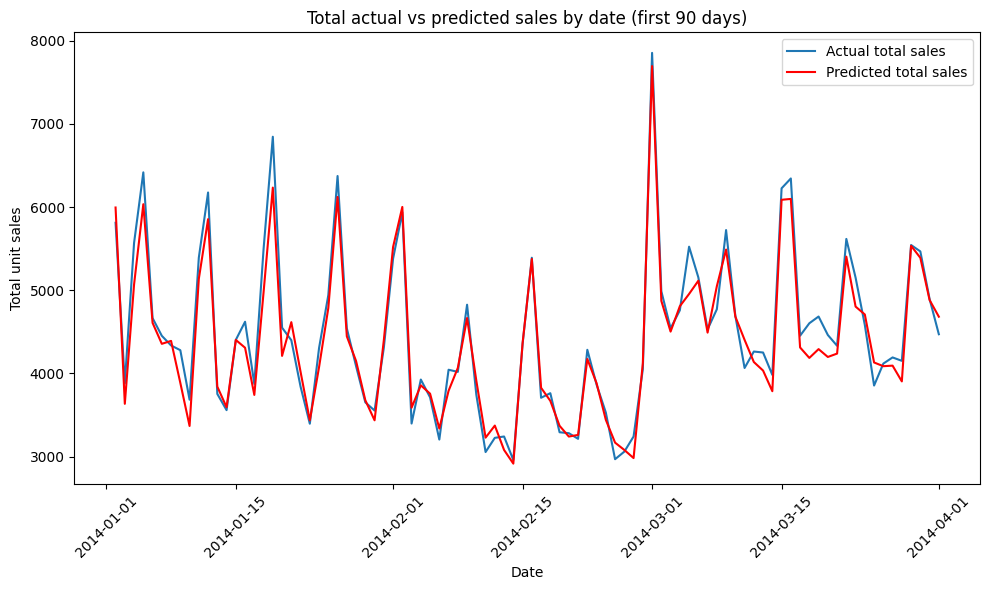

In [ ]:
# Aggregate predictions and actuals by date
plot_df = (
    test_with_date
    .groupby('date')[['y_actual', 'y_pred']]
    .sum()
)

# Plot the first 90 days of actual vs predicted total daily sales
plt.figure(figsize=(10, 6))
plt.plot(plot_df.index[:90], plot_df['y_actual'][:90], label='Actual total sales')
plt.plot(plot_df.index[:90], plot_df['y_pred'][:90], label='Predicted total sales', color='red')

plt.title('Total actual vs predicted sales by date (first 90 days)')
plt.xlabel('Date')
plt.ylabel('Total unit sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Error metrics for the full test set
print("RMSE:", mean_squared_error(y_test, y_pred))  # lower = better fit
print("MAE:", mean_absolute_error(y_test, y_pred))  # lower = average error magnitude

RMSE: 1.7535566489158778
MAE: 0.08546412538999862


# Hyperparameter tuning

This section uses time-series-aware cross-validation to tune key XGBoost hyperparameters.  
Randomized search is used to explore a small but meaningful parameter space while keeping compute manageable.  
The best estimator is then retrained on the full training set and evaluated on the test window.

In [ ]:
# Base model for randomized search
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter search space (small grid, sampled via randomized search)
param_grid = {
    'eta': [0.01, 0.1, 0.3],                # learning rate
    'max_depth': [3, 5, 7],                 # tree depth (model complexity)
    'subsample': [0.7, 0.8, 1.0],            # fraction of rows used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],     # fraction of features used per tree
    'n_estimators': [100, 200, 300]          # number of boosting rounds / trees
}

# Time-series split avoids leakage by preserving temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search over parameter combinations using time-series CV
random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_grid,
    cv=tscv,
    n_iter=10,                              # number of sampled combinations
    scoring='neg_mean_squared_error'        # higher is better (less MSE)
)

# Run the search (n_splits x n_iter fits in total)
random_search.fit(X_train, y_train)

# Best hyperparameters from the search
best_params = random_search.best_params_
print("Best parameters for XGBoost:", best_params)  # best CV configuration

Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.7}


In [ ]:
# Refit the best estimator on the full training set
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [ ]:
# Predict on the test window
y_pred = best_model.predict(X_test)

In [ ]:
# Error metrics for the full test set
print("RMSE:", mean_squared_error(y_test, y_pred))  # lower = better fit
print("MAE:", mean_absolute_error(y_test, y_pred))  # lower = average error magnitude

RMSE: 1.7805410150427172
MAE: 0.10048134792892956


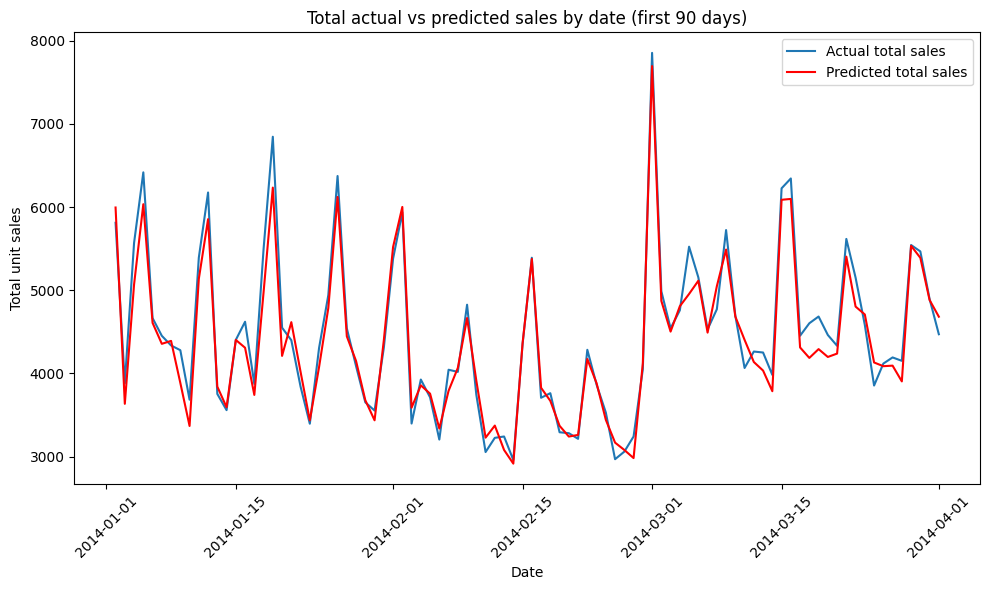

In [ ]:
# Aggregate actual vs predicted totals by date for a quick visual check
plot_df = test_with_date.groupby('date')[['y_actual', 'y_pred']].sum()

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index[:90], plot_df['y_actual'][:90], label='Actual total sales')
plt.plot(plot_df.index[:90], plot_df['y_pred'][:90], label='Predicted total sales', color='red')
plt.title('Total actual vs predicted sales by date (first 90 days)')
plt.xlabel('Date')
plt.ylabel('Total unit sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compute evaluation metrics on the test set
mae = mean_absolute_error(y_test, y_pred)                          # average absolute error
mse = mean_squared_error(y_test, y_pred)                           # average squared error
rmse = np.sqrt(mse)                                                # error in original units

# R² computed manually from residuals
residuals = y_test - y_pred
r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - y_test.mean())**2))  # 1 = perfect fit

print("XGBoost model performance")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"R²:   {r2:.4f}")

XGBoost model performance
RMSE: 1.334369
MAE:  0.100481
MSE:  1.780541
R²:   0.7462
